<a href="https://colab.research.google.com/github/sigmaeon/kaggle-notebooks-uspppm/blob/main/USPPPM_data_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **USPPPM Challenge Data Extraction**
This notebook creates two additional data sets for the USPPPM Kaggle challange:

- A data set based on the training data, where graphical representation of the data is used to augment the existing training data
- A lookup table for commonly used chemical compounds to augment the training data and/or replace chemical formulas with their corresponding name before feeding it to the model at inference time

### Import and Globals


In [1]:
import sys, os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import graphviz as gv
from IPython.display import display, Markdown
from google.colab import data_table
import itertools as it
import torch

sns.set_theme(style="dark")
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
mpl.style.use('seaborn')
mpl.rcParams['text.usetex'] = False   
sns.set(color_codes=True) 

KAGGLE_COMPETITION = 'us-patent-phrase-to-phrase-matching'
KAGGLE_TRAIN_FILE = 'train.csv.zip'
KAGGLE_TEST_FILE = 'test.csv'
PATH_DATA = 'data/'

COLAB = True

def display_md(*args, **kwargs):
    display(Markdown(*args, **kwargs))

def display_sep():
    display_md('<hr><br>')

def display_datatable(data, num_rows_per_page=10):
    if COLAB:
        display(data_table.DataTable(data, include_index=False, num_rows_per_page=num_rows_per_page))
    else:
        display(data)


# cell height
from IPython.display import Javascript
def resize_colab_cell(height=50):
  display(Javascript('google.colab.output.setIframeHeight(0, true, {maxHeight: height})'))

get_ipython().events.register('pre_run_cell', resize_colab_cell)

## Kaggle Setup

In [2]:
# initialize Kaggle API
!pip install -q kaggle
from google.colab import files
import os.path
if not os.path.isfile("/root/.kaggle/kaggle.json"):
    print("Pls select kaggle.json file for Kaggle authentication")
    files.upload()
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print("Initializing things for Kaggle")
from kaggle.api.kaggle_api_extended import KaggleApi
kaggle_api = KaggleApi()
print("Trying to authenticate...")
kaggle_api.authenticate()
print("Done!")


# Download data
print("Downloading data from kaggle...")
kaggle_api.competition_download_file(KAGGLE_COMPETITION, 'train.csv', PATH_DATA)
kaggle_api.competition_download_file(KAGGLE_COMPETITION, 'test.csv', PATH_DATA)
print("Done!")

<IPython.core.display.Javascript object>

Pls select kaggle.json file for Kaggle authentication


Saving kaggle.json to kaggle.json
Initializing things for Kaggle
Trying to authenticate...
Done!


100%|██████████| 680k/680k [00:00<00:00, 66.2MB/s]

100%|██████████| 1.92k/1.92k [00:00<00:00, 1.55MB/s]


Done!


---

# Graph Analysis and Data Extraction
Here we first put the training data in graphical form, where for each phrase we introduce a Node and for each anchor-target-pair we introduce an edge between the corresponding nodes which are weighted according to the corresponding symmilarity score.

Based on this representation we analyse the graphs structure to get a better understanding of how the phrases are linked in the training set.

For the data extraction we additionaly view indentical phrases from different contexts as unique nodes. We then create different data sets based on the connectivity:
- A dataset with *mirrored identity mappings*, where edges between anchor and target phrases with a value of 1 (identity mappings) are swapped and added to the original dataset
- A dataset with all *identity paths*. That is, all phrase-pairs that are in a identity path (path where each link has value 1) are added to the original data set.
- A *mirrored dataset*, where all anchors and targets are swapped
- A dataset that combines *identity path* and the *mirrored data set*
- And a dataset where in addition to the *identity paths*, all neighbors to nodes in a identity path are paired with each node in the path

## Raw Data Analysis

### Raw Data

In [3]:
# data from kaggle
train = pd.read_csv(PATH_DATA + KAGGLE_TRAIN_FILE, compression='zip')

# data from elsewhere
# train =

<IPython.core.display.Javascript object>

In [4]:
display_md('**Training data**')
display(train)
display_sep()

display_md('**General Observations**')
print('#Unique Anchors:',  len(train['anchor'].unique()))
print('#Unique Targets:',  len(train['target'].unique()))
print()
display_md('**Mappings**')
print('#Unique Mappings:', len(train[['anchor','target']].drop_duplicates()))
duplicates = train[train[['anchor','target']].duplicated()]
print('#Duplicate Mappings:', len(duplicates))
print('#Identity Mappings:', len(train[train['anchor'] == train['target']]))
print()
print('Are there duplicates mappings with different scores?')
print(all(train.groupby(by=['anchor', 'target'])['score'].nunique() == 1))

<IPython.core.display.Javascript object>

**Training data**

,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00
...,...,...,...,...,...
36468,8e1386cbefd7f245,wood article,wooden article,B44,1.00
36469,42d9e032d1cd3242,wood article,wooden box,B44,0.50
36470,208654ccb9e14fa3,wood article,wooden handle,B44,0.50
36471,756ec035e694722b,wood article,wooden material,B44,0.75


<hr><br>

**General Observations**

#Unique Anchors: 733
#Unique Targets: 29340



**Mappings**

#Unique Mappings: 33397
#Duplicate Mappings: 3076
#Identity Mappings: 279

Are there duplicates mappings with different scores?
False


## Graph Analysis

#### Utility Functions

In [5]:
def accumulate_along_path(g, p, f, init):
    '''
    Function applying a left-fold along a path
    :param g The graph
    :param p The Path
    :param f Function taking poitional aguments accumulator, edge-pair and edge-data 
    :param init Initlial value for the accumulator.
    '''
    s = g.subgraph(p)
    # path has to be connected
    assert(nx.has_path(s, p[0], p[-1]))
    path_edges = zip(p, p[1:])
    
    acc = init
    for e in path_edges:
        acc = f(acc, e, s.get_edge_data(*e))
    
    return acc

def path_weight_product(g, p):
    return accumulate_along_path(g, p, lambda acc, e, data: acc*data['weight'], init=1)

def path_contexts(g, p): 
    return accumulate_along_path(g, p, lambda acc, e, data: acc + [data['context']], init=list())

def path_unique_contexts(g, p):
    return set(path_contexts(g, p))

def path_unique_context_count(g, p):
    return len(path_unique_contexts(g, p))

<IPython.core.display.Javascript object>

#### Directed Graph from Raw Data

We first remove identity mappings i.e. self-loops.  
Duplicated links are ignored -> no multi graph

In [6]:
g = nx.DiGraph()

train_nonequal = train[train['anchor'] != train['target']]
e = train_nonequal.apply(lambda row: (row['anchor'], row['target'], 
                             {'weight': row['score'], 
                              'context': row['context'],
                              'id':row['id']}), axis=1)
print("Example edge:")
print(e[0])
g.add_edges_from(e)

<IPython.core.display.Javascript object>

Example edge:
('abatement', 'abatement of pollution', {'weight': 0.5, 'context': 'A47', 'id': '37d61fd2272659b1'})


<IPython.core.display.Javascript object>

### Full Graph

DiGraph with 29815 nodes and 33151 edges
Cycles: [['source voltage', 'source channel']]


*We only have one mapping that has a path back to itself*

### Components

DiGraph with 29384 nodes and 32740 edges
Out degrees {0, 1, 2, 4, 6, 7, 8, 12, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 88, 89, 90, 92, 93, 94, 95, 97, 98, 100, 103, 105, 107, 113, 118, 120, 123, 127, 128}
In degrees {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 24}

DiGraph with 23 nodes and 22 edges
Out degrees {0, 22}
In degrees {0, 1}

DiGraph with 22 nodes and 21 edges
Out degrees {0, 21}
In degrees {0, 1}

DiGraph with 27 nodes and 26 edges
Out degrees {0, 26}
In degrees {0, 1}

DiGraph with 2 nodes and 1 edges
Out degrees {0, 1}
In degrees {0, 1}

DiGraph with 22 nodes and 21 edges
Out degrees {0, 21}
In degrees {0, 1}

DiGraph with 31 nodes and 30 edges
Out degrees {0, 30}
In degrees {0, 1}

DiGraph with 3 nodes and 2 edge

**One big component. The rest consist of single anchors that only map to unique targets** <br> E.g.

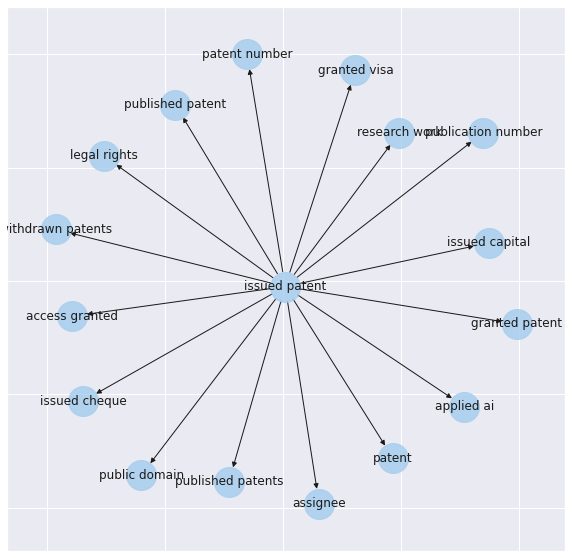

In [7]:
display_md('### Full Graph')
print(nx.info(g))
# sanity check
#nx.number_of_selfloops(g)
print('Cycles:', list(nx.simple_cycles(g)))
display_md('*We only have one mapping that has a path back to itself*')
components = [g.subgraph(c) for c in nx.weakly_connected_components(g)]


display_md('### Components')
for c in components:
    print(nx.info(c))
    print('Out degrees', set(dict(c.out_degree).values()))
    print('In degrees', set(dict(c.in_degree).values()))
    print()

display_md('**One big component. The rest consist of single anchors that only map to unique targets** <br> E.g.')
plt.figure(figsize=(10, 10))
plt.axis()
nx.draw_networkx(components[12], node_color='#a3ccedcc', node_size=900)

##### Mappings with single anchor and unique target

In [8]:
single_anchor_comps = components[1:]
for c in single_anchor_comps:
    display_datatable(nx.to_pandas_edgelist(c), num_rows_per_page=5)
    #display(nx.to_pandas_edgelist(c))
    display_sep()

<IPython.core.display.Javascript object>

,source,target,context,weight,id
0,automatic coffee,auto spares,A47,0.00,0f80b5de135d084f
1,automatic coffee,automated coffee device,A47,0.50,9fdcb9bba40fa42c
2,automatic coffee,automated coffee machine,A47,0.50,cbe91527182c7c51
3,automatic coffee,automated coffee vending device,A47,0.50,145baaedc7633ce2
4,automatic coffee,automated coffee vending machine,A47,0.50,b7627918b41a7f3b
5,automatic coffee,automated machine,A47,0.50,1df5291f66ca33bf
6,automatic coffee,automated testing,A47,0.00,b46dc0369c3b6975
7,automatic coffee,automatic beverage,A47,0.25,61b68976a9a534cb
8,automatic coffee,automatic car,A47,0.00,a85d431d9e3ba97d
9,automatic coffee,automatic cars,A47,0.00,925ccd5c09ef3ff5


<hr><br>

,source,target,context,weight,id
0,churned,beating eggs,A01,0.25,0194c3de04ef7178
1,churned,butter churn,A01,0.50,aff10e4311416b48
2,churned,butter making,A01,0.25,415718a897aa7e66
3,churned,butter paper,A01,0.00,3b85ce12ad2db258
4,churned,churned milk,A01,0.50,096ca9786023989a
5,churned,churning butter,A01,0.50,8bdbf0caa2fb313d
6,churned,churning cocoa butter,A01,0.50,ff1355f1d7ddccd5
7,churned,churning cream,A01,0.50,984408f8e42b0279
8,churned,churning sweet cream,A01,0.50,170d5051ea68326c
9,churned,cocoa,A01,0.25,603ffdcd0a398ef8


<hr><br>

,source,target,context,weight,id
0,comprise in refinement,adaptive mesh refinement,H02,0.50,914fdbea9f6baa31
1,comprise in refinement,adaptive refinement,H02,0.50,46e6966f37c45ffd
2,comprise in refinement,coal refinement,H02,0.00,24d84343cbb53cdc
3,comprise in refinement,comprise in further refinement,H02,0.75,9af0bb1805c0f488
4,comprise in refinement,comprises processing unit,H02,0.25,ed797a0fa3896cd3
5,comprise in refinement,consist in refinement,H02,0.75,4c554e7fb3899628
6,comprise in refinement,disc refiner,H02,0.25,dc7d77ff80a40048
7,comprise in refinement,electrode refinement,H02,0.50,c4b58941f37bd66d
8,comprise in refinement,energy minimization,H02,0.25,43659b4163919cd5
9,comprise in refinement,energy models,H02,0.25,4ea33b3719830fab


<hr><br>

,source,target,context,weight,id
0,conduct conducting material,conduct material,C04,0.5,22337fd3dde51665


<hr><br>

,source,target,context,weight,id
0,cut from stack,agricultural waste,A01,0.25,c35a73f6c09f5583
1,cut from stack,call stack,A01,0.00,07bf3c29cb1bbb9a
2,cut from stack,cut and stack,A01,0.75,4a5c63dd501d8210
3,cut from stack,cut and stack labeling equipment,A01,0.50,b3f09f39bc175b23
4,cut from stack,cut off from people,A01,0.00,a0e83fd480eac9f1
5,cut from stack,cut off marks,A01,0.00,8daca91bc7bdddbb
6,cut from stack,cut off scores,A01,0.00,8b99db7e777c7bfb
7,cut from stack,cut shoes,A01,0.00,193e92f9b1ee92aa
8,cut from stack,cut stack,A01,0.50,285a310b2be58ff1
9,cut from stack,die cuts,A01,0.50,cb4d12f4bb9744b0


<hr><br>

,source,target,context,weight,id
0,decreased power,decrease file size,H01,0.00,862cef22981e118f
1,decreased power,decrease image size,H01,0.00,e3618f806af41452
2,decreased power,decrease resolution of image,H01,0.00,76b9c997a81b33e7
3,decreased power,decrease symbol,H01,0.00,4e8896f70420da89
4,decreased power,decreased operating power,H01,0.75,e0334e4e5b223c4f
5,decreased power,decreased wbc count,H01,0.00,920b862867e1569a
6,decreased power,decreasing order,H01,0.00,8046347fcc0403a0
7,decreased power,deep sleep mode,H01,0.25,67c5cae613a71f7c
8,decreased power,full load power,H01,0.25,9a00018dced32c5e
9,decreased power,increased power,H01,0.25,f75c158ce743a2c9


<hr><br>

,source,target,context,weight,id
0,dry coating composition1,food composition,A23,0.25,3a20f8d3a1f35c7e
1,dry coating composition1,uncoated tablets,A23,0.25,08abe496af27410e


<hr><br>

,source,target,context,weight,id
0,further additional elements,additional hard disc,B81,0.00,93a6b67d5b05d6fb
1,further additional elements,additional kitchen cabinets,B81,0.00,416f36d6891f5165
2,further additional elements,additional manpower,B81,0.00,d05a10a807d0bef0
3,further additional elements,additional plate elements,B81,0.50,e01e6eacd8a073d7
4,further additional elements,additional system,B81,0.50,cc79805b7580bd9e
5,further additional elements,auxiliary extra elements,B81,0.75,5dd4556946b02462
6,further additional elements,biocompatible polymer,B81,0.25,5e696e31f2cf03e5
7,further additional elements,elements of the hard disk,B81,0.00,8bcc60d68049a5f2
8,further additional elements,extra elements,B81,0.75,1ca241503a5414f3
9,further additional elements,further additional,B81,0.50,581f9946153ec6df


<hr><br>

,source,target,context,weight,id
0,general anesthesia,anaphylaxis,A61,0.00,8aaddb391f26733b
1,general anesthesia,etomidate,A61,0.50,cf5677188a11d2d1
2,general anesthesia,general adaptation,A61,0.00,c060eb0ca34f3d81
3,general anesthesia,general coach,A61,0.00,33d5b72fb657959d
4,general anesthesia,general knowledge,A61,0.00,6e98c224f0a30eef
5,general anesthesia,general physician,A61,0.00,05517e45269a5b30
6,general anesthesia,general store,A61,0.00,f0af6a9d415a0283
7,general anesthesia,intravenous,A61,0.25,99db6a96031bed98
8,general anesthesia,local anesthesia,A61,0.50,fffd19c1c50fc108
9,general anesthesia,loss of memory,A61,0.25,32abd52876a10d0c


<hr><br>

,source,target,context,weight,id
0,hrb,bus tracking,H04,0.00,3ad7755222495e16
1,hrb,computer resource bus,H04,0.50,b628a4a1268dedc5
2,hrb,frequency hrb,H04,0.50,996f625b648e6b36
3,hrb,hardware acceleration,H04,0.00,f18518f79665c429
4,hrb,hardware resource bus,H04,0.75,b3795e834aa3c695
5,hrb,hardware resource over a bus,H04,0.75,6d4dff9fdfcb0af6
6,hrb,herb plants,H04,0.00,4c1b20fef2d1594a
7,hrb,high rate bit,H04,0.75,07430e5268cf68d3
8,hrb,high risk borrower,H04,0.00,792af9ce7dfa9aeb
9,hrb,hrb detectors,H04,0.50,7b8f92fee84ec258


<hr><br>

,source,target,context,weight,id
0,implement with plurality,device with plurality,A01,0.50,0d11e6b9958829f4
1,implement with plurality,farm tool,A01,0.25,013d54e94b342a24
2,implement with plurality,farming tool,A01,0.25,362c0fe40530e119
3,implement with plurality,implement law,A01,0.00,7b0c48d367aae1d7
4,implement with plurality,implement plurality,A01,0.75,2f830cb57509013f
5,implement with plurality,implement regulations,A01,0.00,98756be1e94c38ad
6,implement with plurality,implement rules,A01,0.00,ebc17d315a4f0d29
7,implement with plurality,implementation of multiple,A01,0.50,64e7b841e22436da
8,implement with plurality,implemented last year,A01,0.00,39e44ab0fd126f23
9,implement with plurality,implying plurality,A01,0.50,a326915f747e956c


<hr><br>

,source,target,context,weight,id
0,issued patent,access granted,F23,0.00,2df133648fb41d7d
1,issued patent,applied ai,F23,0.00,feadd1fd8e365204
2,issued patent,assignee,F23,0.25,f0f751fb42d28c8f
3,issued patent,granted patent,F23,0.75,58529412952f6c70
4,issued patent,granted visa,F23,0.00,9da2187732ba0e78
5,issued patent,issued capital,F23,0.00,6151bf0b99448def
6,issued patent,issued cheque,F23,0.00,85cd0fd54a84a26e
7,issued patent,legal rights,F23,0.50,023300eee3d21b78
8,issued patent,patent,F23,0.50,2bff53e1269b8bc5
9,issued patent,patent number,F23,0.25,d75de86698a7d650


<hr><br>

,source,target,context,weight,id
0,killed,aluminum killed steel,C12,0.00,d9accb69e031a3cb
1,killed,inactivated,G02,0.75,b6b4da2405b1c655
2,killed,killed steel,C12,0.00,044e98e40ec4c225
3,killed,live,C12,0.25,e22ebcea0b99aeea
4,killed,shock killed,C12,0.50,b4b97f2cc6af754c
5,killed,alive,G02,0.25,7c8925c8f2c488af
6,killed,application killed,G02,0.00,2edcc448fc98d0b4
7,killed,cold and heat,G02,0.00,5983089372dab08c
8,killed,cold killing,G02,0.50,65cc4811c8734396
9,killed,heat killed,G02,0.50,86b5060a408b896c


<hr><br>

,source,target,context,weight,id
0,parallel force,adhesive force,F28,0.25,c2e90b5cddea75f4
1,parallel force,air force,F28,0.00,d5c4a0862923f8ec
2,parallel force,airforce,F28,0.00,5bccd900dbbdac17
3,parallel force,centrifugal,F28,0.50,bde5b0ea10bda1bb
4,parallel force,cohesive force,F28,0.25,a0be9b4e8dd4418f
5,parallel force,equal magnitude,F28,0.75,3601a8565dab9c8b
6,parallel force,equal magnitude act,F28,0.75,a5e81c14a8d7ef36
7,parallel force,force acting,F28,0.25,af315cffe2908fcc
8,parallel force,force in same direction,F28,0.75,e271cdeefd39f5a2
9,parallel force,force in same plane,F28,0.75,14b471cd3272414d


<hr><br>

,source,target,context,weight,id
0,perform working operations,brain working recursive therapy,B21,0.00,ea23b5945bc1cb32
1,perform working operations,execute operations,B21,0.75,ab494bdc7e396bfc
2,perform working operations,execute working operation,B23,0.75,9eeb55f03355c8d1
3,perform working operations,finish working operation,B21,0.25,3ab2b37192725bd8
4,perform working operations,implement work task,B23,0.75,54986a03b80abcd6
5,perform working operations,job handling,B23,0.50,9c5696d0531a5596
6,perform working operations,laser operation,B23,0.00,882493d5b3496fba
7,perform working operations,leg operation,B21,0.00,741dc510cb4c4ae6
8,perform working operations,metal working operations,B23,0.50,6fb581f4400ba10e
9,perform working operations,milling operation,B23,0.25,9edfac2e68996c37


<hr><br>

,source,target,context,weight,id
0,post hole diggers,agricultural tool,A01,0.50,cc84245089c0bd21
1,post hole diggers,carrom hole,A01,0.00,600eaf850753a6fe
2,post hole diggers,diggers,A01,0.50,bfd8b2771874ee61
3,post hole diggers,digging pits,A01,0.50,2c88d905292089df
4,post hole diggers,digging tool,A01,0.50,ecd3031b8de0e659
5,post hole diggers,drill hole marker,A01,0.00,80057677bd4c12c6
6,post hole diggers,farming tools,A01,0.50,b879eec20edc665a
7,post hole diggers,fencing process,A01,0.25,bc4b437d12d817c7
8,post hole diggers,fire in the hole,A01,0.00,fad7dae3dd037217
9,post hole diggers,garden tools,A01,0.50,2ef00d29a409af47


<hr><br>

,source,target,context,weight,id
0,prevent accidental separation,accidental insurance,A44,0.00,e985d93c3f55a9ee
1,prevent accidental separation,accidental separation,A44,0.50,88e51c330e0497b5
2,prevent accidental separation,accidents prevention,A44,0.00,beb17aabca99f231
3,prevent accidental separation,avert accidental separation,A44,0.75,ae5cc659373ad8b5
4,prevent accidental separation,avert separation,A44,0.50,eb50931ada682e35
5,prevent accidental separation,halt accidental separation,A44,0.75,dd013415cf5852a5
6,prevent accidental separation,halt separation,A44,0.50,0eef269cf394effc
7,prevent accidental separation,permit separation,A44,0.25,a89297c1ee407499
8,prevent accidental separation,preclude accidental separation,A44,0.75,97402e0c5e26eafd
9,prevent accidental separation,preclude removal,A44,0.50,eb4a08aa75494012


<hr><br>

,source,target,context,weight,id
0,send to control node,control anger,H04,0.00,017ea40743199855
1,send to control node,controlling mechanism operator,H04,0.50,46342a464f59a433
2,send to control node,forward market,H04,0.00,57151d854472ba8a
3,send to control node,forward to node,H04,0.50,21809bdbf6037284
4,send to control node,lymph node,H04,0.00,50cd3c1af416fac6
5,send to control node,receive control signals,H04,0.25,86edb06c57603b70
6,send to control node,receive from the control unit,H04,0.25,e3e9cf97c8e72236
7,send to control node,receiving data,H04,0.25,f89686cca84d7b56
8,send to control node,response from control system,H04,0.25,340b530bc03f37db
9,send to control node,send by node,H04,0.25,3ba4268dea7bfad6


<hr><br>

,source,target,context,weight,id
0,shannon,shannon fano,D03,0.50,e5cd685df185e766
1,shannon,shannon entropy,F28,0.75,9f376d1b6080d4cc


<hr><br>

,source,target,context,weight,id
0,shape like tail,cone design,A63,0.25,360af4082125287d
1,shape like tail,dove tail shape,A63,0.50,f071e3bc5df15854
2,shape like tail,figure like tail,A63,0.50,da50e167fd21bda8
3,shape like tail,form in like shape,A63,0.25,a43d43c75bd29e81
4,shape like tail,shape like back end,A63,0.50,39653093961b9ba8
5,shape like tail,shape like bird part,A63,0.25,560803e7f412af53
6,shape like tail,shape like cone,A63,0.50,e8d4b3ac58c6d0f8
7,shape like tail,shape like end,A63,0.25,c672ab9304c28997
8,shape like tail,shape like portion,A63,0.50,a811b1bd4eb90c7c
9,shape like tail,shape like scut,A63,0.50,eb28cd6611b3c399


<hr><br>

##### Shortest Paths

In [9]:
%%time
c0 = components[0]
sp_dict = dict(nx.shortest_path(c0, weight=None))
c0_shortest_paths = pd.DataFrame([[s,t,p] for s, ps in sp_dict.items() for t,p in ps.items()], columns=['anchor', 'target', 'path'])

<IPython.core.display.Javascript object>

CPU times: user 1.13 s, sys: 11.3 ms, total: 1.14 s
Wall time: 1.31 s


Shortest Path Stats

In [10]:
%%time
c0_shortest_paths['length'] = c0_shortest_paths.apply(lambda row: len(row['path']) - 1, axis=1)
c0_shortest_paths['contexts'] = c0_shortest_paths['path'].apply(lambda p: path_unique_contexts(c0, p))
c0_shortest_paths['context_cnt'] = c0_shortest_paths['path'].apply(lambda p: path_unique_context_count(c0, p))
c0_shortest_paths['path_cnt'] = c0_shortest_paths.apply(lambda row: len(list(nx.all_simple_paths(c0, row['anchor'], row['target']))), axis=1)
c0_shortest_paths

<IPython.core.display.Javascript object>

CPU times: user 9min 13s, sys: 2.29 s, total: 9min 15s
Wall time: 9min 26s


Product of path weights of length 2 paths

In [11]:
display(c0_shortest_paths)
display_sep()

display_md("**Stats**")
print("#Length0 paths:", (c0_shortest_paths['length'] == 0).sum())

c0_shortest_nz_paths =  c0_shortest_paths[c0_shortest_paths['length'] != 0]
print('Non-zero sp lengths')
print(c0_shortest_nz_paths['length'].value_counts())
print()
print('Nr. simple paths')
print(c0_shortest_nz_paths['path_cnt'].value_counts())
print()
print('Unique context count')
print(c0_shortest_nz_paths['context_cnt'].value_counts())
print('#Length 2 Paths with equal context', sum((c0_shortest_nz_paths['length']>1) & (c0_shortest_nz_paths['context_cnt']==1)))
print('#Length 2 Paths with different context', sum((c0_shortest_nz_paths['length']>1) & (c0_shortest_nz_paths['context_cnt'] > 1)))

<IPython.core.display.Javascript object>

,anchor,target,path,length,contexts,context_cnt,path_cnt
0,abatement,abatement,[abatement],0,{},0,0
1,abatement,abatement of pollution,"[abatement, abatement of pollution]",1,{A47},1,1
2,abatement,act of abating,"[abatement, act of abating]",1,{A47},1,1
3,abatement,active catalyst,"[abatement, active catalyst]",1,{A47},1,1
4,abatement,eliminating process,"[abatement, eliminating process]",1,{A47},1,1
...,...,...,...,...,...,...,...
63226,wood apple fruit,wood apple fruit,[wood apple fruit],0,{},0,0
63227,wood logs,wood logs,[wood logs],0,{},0,0
63228,wood substrate,wood substrate,[wood substrate],0,{},0,0
63229,wooden material,wooden material,[wooden material],0,{},0,0


<hr><br>

**Stats**

#Length0 paths: 29384
Non-zero sp lengths
1    32740
2     1107
Name: length, dtype: int64

Nr. simple paths
1    33819
2       28
Name: path_cnt, dtype: int64

Unique context count
1    32846
2     1001
Name: context_cnt, dtype: int64
#Length 2 Paths with equal context 106
#Length 2 Paths with different context 1001


#### Undirected Graph from Raw Data

We first remove identity mappings i.e. self-loops.  
Duplicated links are ignored -> no multi graph.
We add the context to the anchor and target text s.t. a same words with different conexts are represented by different nodes

In [12]:
g = nx.Graph()

train_g = train.copy()
# make anchors and targets unique in regardas to context
train_g['anchor_ctx'] = train_g['anchor'] +" [" + train_g['context'] + "]" 
train_g['target_ctx'] = train_g['target'] +" [" + train_g['context'] + "]" 

# throw out any exiting self-loops
train_g = train_g[train_g['anchor_ctx'] != train_g['target_ctx']]



e = train_g.apply(lambda row: (row['anchor_ctx'], row['target_ctx'], 
                             {'weight': row['score'], 
                              'anchor': row['anchor'],
                              'target': row['target'],
                              'context': row['context'],
                              'id':row['id']}), axis=1)
print("Example edge:")
print(e[0])
g.add_edges_from(e)

<IPython.core.display.Javascript object>

Example edge:
('abatement [A47]', 'abatement of pollution [A47]', {'weight': 0.5, 'anchor': 'abatement', 'target': 'abatement of pollution', 'context': 'A47', 'id': '37d61fd2272659b1'})


In [13]:
display_md('### Full Graph')
print(nx.info(g))
components = [g.subgraph(c) for c in nx.connected_components(g)]


display_md('### Components')
print("Found ", len(components), " components")
print()

single_edge_components = []
star_like_components = []
complex_components = []
for c in components:
    degrees = np.array(list(dict(c.degree).values()))
    # components with a single edge
    if len(c.edges) == 1:
        single_edge_components.append(c)
    # Components that have one central node with degree N-1
    # and all remaining nodes with degree of 1 - i.e. star-like
    elif sum(degrees == len(degrees) - 1) == 1 and sum(degrees == 1) == len(degrees) - 1:
        star_like_components.append(c)
    else:
        complex_components.append(c)

print("# single-edge components:", len(single_edge_components))
print("# star-like components:", len(star_like_components))
print("# 'complex' components:", len(complex_components))

<IPython.core.display.Javascript object>

### Full Graph

Graph with 37266 nodes and 36194 edges


### Components

Found  1228  components

# single-edge components: 148
# star-like components: 936
# 'complex' components: 144


-> single-edge and star-like components are not relevant for us for now

##### Complex components

In [14]:
# Lets get some basic stats
c_infos = []
bridge_nodes = []
for c in complex_components:
    info = {}
    info["N"] = len(c.edges)
    info["M"] = len(c.nodes)
    degs = np.array(list(dict(c.degree).values()))
    info["MeanDeg"] = np.mean(degs)
    info["MinDeg"] = np.min(degs)
    info["MaxDeg"] = np.max(degs)
    info["NrDegEq1"] = sum(degs == 1)
    info["NrDegEq2"] = sum(degs == 2)
    info["NrDegGt3"] = sum(degs > 3)
    info["Diameter"] = nx.diameter(c)
    bridges = list(nx.bridges(c))
    info["NrBridges"] = len(bridges)
    bridge_nodes.append(bridges)
    c_infos.append(info)
    
c_infos = pd.DataFrame(c_infos)

<IPython.core.display.Javascript object>

**Sizes**

<IPython.core.display.Javascript object>

Complex components account for 16315 (44.73%) entries of the training set
Smallest component has 17 edges
Biggest component has 1109 edges



**Histogram of component sizes**

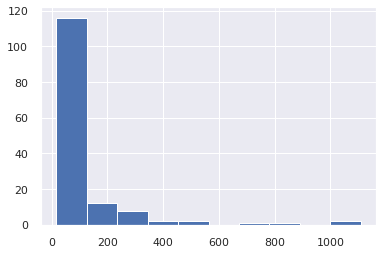

**Histogram of diameters**

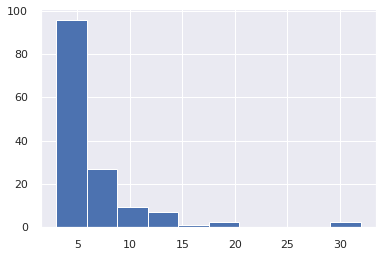

Unique diameters: [3, 4, 6, 8, 10, 12, 14, 16, 18, 20, 30, 32]


In [15]:
print("Complex components account for {} ({:.4g}%) entries of the training set".format(c_infos["N"].sum(), c_infos["N"].sum()/len(train) * 100))
print("Smallest component has", min(c_infos["N"]), "edges")
print("Biggest component has", max(c_infos["N"]), "edges")
print()
display_md("**Histogram of component sizes**")
ax = c_infos["N"].hist()
plt.show()

display_md("**Histogram of diameters**")
c_infos["Diameter"].hist()
plt.show()
print("Unique diameters:", sorted(c_infos["Diameter"].unique()))

**Degrees**

<IPython.core.display.Javascript object>

**Histogram of ratios between maximum degree and total edge count**

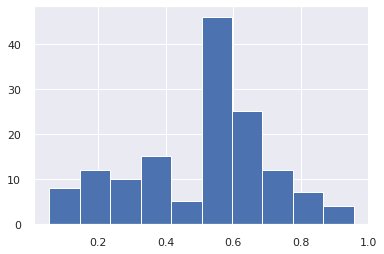

<hr><br>

**Histograms for degree-node ratios**

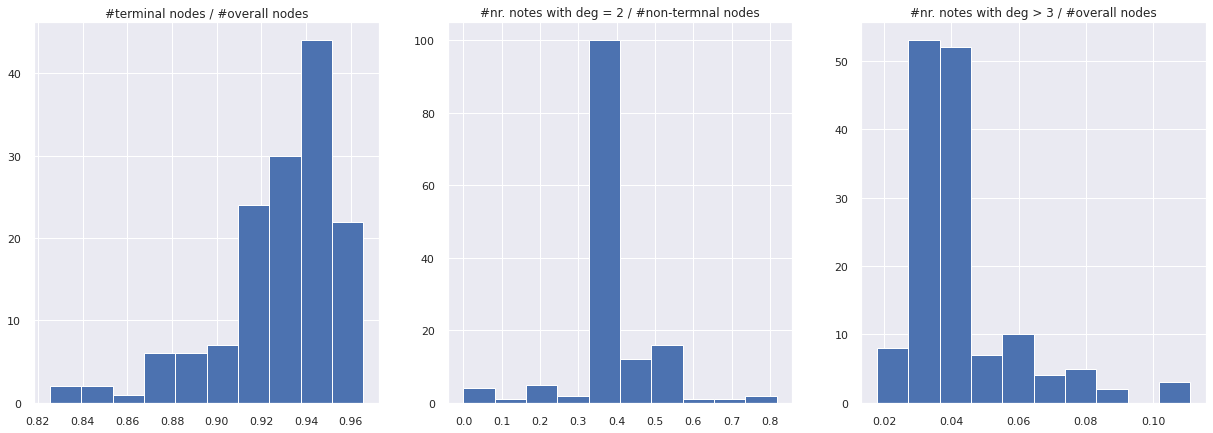

In [16]:
display_md("**Histogram of ratios between maximum degree and total edge count**")
(c_infos["MaxDeg"]/c_infos["N"]).hist()
plt.show()
display_sep()

display_md("**Histograms for degree-node ratios**")
f = plt.figure(figsize=(21,7))
ax = f.add_subplot(131)
ax.set_title("#terminal nodes / #overall nodes")
(c_infos["NrDegEq1"]/c_infos["M"]).hist(ax=ax)

ax = f.add_subplot(132)
ax.set_title("#nr. notes with deg = 2 / #non-termnal nodes")
(c_infos["NrDegEq2"]/(c_infos["M"] - c_infos["NrDegEq1"])).hist(ax=ax)

ax = f.add_subplot(133)
ax.set_title("#nr. notes with deg > 3 / #overall nodes")
(c_infos["NrDegGt3"]/c_infos["M"]).hist(ax=ax)
plt.show()

**Other Stats**

<IPython.core.display.Javascript object>

**Historgram of the ratios between number of bridge and number of edges**

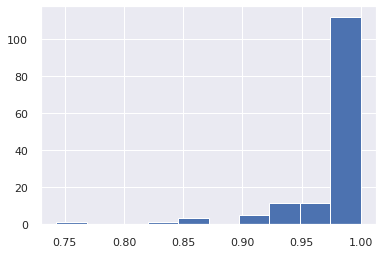

**Same histogram but excluding bridges to terminal nodes**

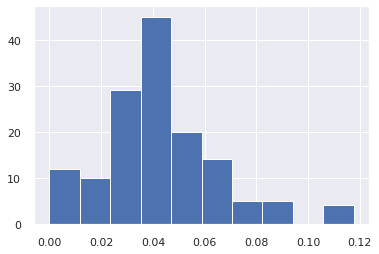

In [17]:
display_md("**Historgram of the ratios between number of bridge and number of edges**")
(c_infos["NrBridges"] / c_infos["N"]).hist()
plt.show()
display_md("**Same histogram but excluding bridges to terminal nodes**")
((c_infos["NrBridges"] - c_infos["NrDegEq1"]) / c_infos["N"]).hist()

## Data Extraction

#### Preparations

Utility functions

In [ ]:
# swaps targets and anchors while keeping the scores, context etc.
# and append the result to the input data frame.
# Removes duplicates of anchor-target-context-combinations after the merge.
# the id is suffixed with a '_2'
def add_mirror_mappings(data):
    mirrored_data = data.rename(columns={'anchor':'target', 'target':'anchor'})
    mirrored_data['id'] = mirrored_data['id'] + '_2'
    result = pd.concat([data, mirrored_data], ignore_index=True).drop_duplicates(subset=['anchor', 'target', 'context', 'score'])
    # warning if there are still duplicates of anchor-target-context-combinations 
    # -> that means we have a sc
    if (any(result.value_counts(subset=['anchor', 'target', 'context']) > 1)):
        print("WARNING! There are equivalent mappings with different scores!")

    return result

# graph used here consist of nodes storing phrases and contexts and edges storing scores and ids
# this functions are used to generate a dataset from such a graph

# extract anchor, targe and context from the given edge in graph G
def mapping_data_from_edge(G, edge):
    source_node = G.nodes(data=True)[edge['source']]
    target_node = G.nodes(data=True)[edge['target']]
    return source_node['phrase'], target_node['phrase'], source_node['context']

def graph_to_dataset(G):
    edges_df = nx.to_pandas_edgelist(G)
    edges_df[['anchor', 'target', 'context']] = edges_df.apply(lambda row: mapping_data_from_edge(G, row), 
                                                               axis=1, result_type='expand')
    # trim to relevant data only
    edges_df = edges_df[['id', 'anchor', 'target', 'score', 'context']]
    # add symmetric relations
    return add_mirror_mappings(edges_df)

<IPython.core.display.Javascript object>

**Prepare Graph Data**

In [ ]:
train_g = train.copy()
# make anchors and targets unique in regardas to context
train_g['anchor_ctx'] = train_g['anchor'] +" [" + train_g['context'] + "]" 
train_g['target_ctx'] = train_g['target'] +" [" + train_g['context'] + "]" 

# throw out any existing self-loops
train_g = train_g[train_g['anchor_ctx'] != train_g['target_ctx']]

<IPython.core.display.Javascript object>

**Full Graph**

In [ ]:
G = nx.from_pandas_edgelist(train_g, source='anchor_ctx', target='target_ctx', edge_attr=['score', 'id'])
# set attributes of anchor nodes 
anchor_node_attributes = train_g[['anchor_ctx', 'anchor', 'context']].drop_duplicates().set_index('anchor_ctx').rename(columns={'anchor':'phrase'}).T.to_dict()
nx.set_node_attributes(G, anchor_node_attributes)

# set attributes of target nodes 
target_node_attributes = train_g[['target_ctx', 'target', 'context']].drop_duplicates().set_index('target_ctx').rename(columns={'target':'phrase'}).T.to_dict()
nx.set_node_attributes(G, target_node_attributes)

print("Nr. Edges:", len(G.edges))
print("Nr. Nodes:", len(G.nodes))
print()
print("Example edge:")
print(list(G.edges(data=True))[0])
print()
print("Example node")
print(list(G.nodes(data=True))[0])

<IPython.core.display.Javascript object>

Nr. Edges: 36194
Nr. Nodes: 37266

Example edge:
('abatement [A47]', 'abatement of pollution [A47]', {'score': 0.5, 'id': '37d61fd2272659b1'})

Example node
('abatement [A47]', {'phrase': 'abatement', 'context': 'A47'})


**Identity mappings**

Create identity graph

In [ ]:
#G_ident = nx.from_pandas_edgelist(train_g[train_g['score'] == 1], source='anchor_ctx', target='target_ctx', edge_attr=True)
identity_edges = list(train_g[train_g['score'] == 1][['anchor_ctx', 'target_ctx']].itertuples(index=False, name=None))
G_ident = G.edge_subgraph(identity_edges).copy()
print("Nr. Edges:", len(G_ident.edges))
print("Nr. Nodes:", len(G_ident.nodes))
print()
print("Example edge:")
print(list(G_ident.edges(data=True))[0])
print()
print("Example node")
print(list(G_ident.nodes(data=True))[0])

<IPython.core.display.Javascript object>

Nr. Edges: 875
Nr. Nodes: 1424

Example edge:
('rotary electric [F01]', 'rotary electrical [F01]', {'score': 1.0, 'id': 'dab4e1ee81a1e0d6'})

Example node
('rotary electric [F01]', {'phrase': 'rotary electric', 'context': 'F01'})


Create edges for existing paths in the identity graph

In [ ]:
identity_paths = nx.shortest_path(G_ident)
identity_paths_df = pd.DataFrame([[s,t,  # anchor_ctx, target_ctx
                                   G_ident.nodes[p[0]]['phrase'], G_ident.nodes[p[-1]]['phrase'], # anchor and target phrase
                                   1, 'identity_'+str(i), G_ident.nodes[p[0]]['context'], # score, id, context
                                   p, len(p)] # path, path_length
                                  for i, (s, ps) in enumerate(identity_paths.items())
                                  for t, p in ps.items()], 
                                 columns=['anchor_ctx', 'target_ctx', 
                                          'anchor', 'target', 
                                          'score', 'id', 'context',
                                          'path', 'path_length'])
# remove single node paths
identity_paths_df = identity_paths_df[identity_paths_df['path_length'] > 1]
# for late use we store all paths that are not self mappings 
identity_path_mappings = add_mirror_mappings(identity_paths_df[['id', 'anchor', 'target', 'score', 'context']])
identity_path_mappings = identity_path_mappings.drop_duplicates(subset=['anchor', 'target', 'context'])

identity_path_edges = [(anchor_ctx, target_ctx, {'score':score, 'id':id}) for 
                       (anchor_ctx, target_ctx, score, id) in 
                       identity_paths_df[['anchor_ctx', 'target_ctx', 'score', 'id']].itertuples(index=False, name=None)]

# for the graph we are only interested in paths > 2, since the rest already has an edge
multiedge_identity_paths_df = identity_paths_df[identity_paths_df['path_length'] > 2]
print("Found", len(multiedge_identity_paths_df), "additional identity 'paths' with the longest being of length", multiedge_identity_paths_df['path_length'].max())

display(multiedge_identity_paths_df)

# creating new edges from the found paths
multiedge_identity_path_edges = [(anchor_ctx, target_ctx, {'score':score, 'id':id}) for 
                  (anchor_ctx, target_ctx, score, id) in 
                  multiedge_identity_paths_df[['anchor_ctx', 'target_ctx', 'score', 'id']].itertuples(index=False, name=None)]
print("Example edge:")
print(multiedge_identity_path_edges[0])
print(len((multiedge_identity_path_edges)))

<IPython.core.display.Javascript object>

Found 1040 additional identity 'paths' with the longest being of length 3


,anchor_ctx,target_ctx,anchor,target,score,id,context,path,path_length
4,selectable operation [B64],selected operations [B64],selectable operation,selected operations,1,identity_1,B64,"[selectable operation [B64], selected operatio...",3
7,lifting elements [B62],element lift [B62],lifting elements,element lift,1,identity_2,B62,"[lifting elements [B62], lift element [B62], e...",3
8,lifting elements [B62],lifting element [B62],lifting elements,lifting element,1,identity_2,B62,"[lifting elements [B62], lift element [B62], l...",3
19,compounds of aluminium [C07],aluminum containing compounds [C07],compounds of aluminium,aluminum containing compounds,1,identity_6,C07,"[compounds of aluminium [C07], aluminium compo...",3
20,compounds of aluminium [C07],aluminum compounds [C07],compounds of aluminium,aluminum compounds,1,identity_6,C07,"[compounds of aluminium [C07], aluminium compo...",3
...,...,...,...,...,...,...,...,...,...
4181,slot opened [A61],slot opening [A61],slot opened,slot opening,1,identity_1412,A61,"[slot opened [A61], slot open [A61], slot open...",3
4182,slot opened [A61],slots open [A61],slot opened,slots open,1,identity_1412,A61,"[slot opened [A61], slot open [A61], slots ope...",3
4185,distal end of the catheter [B65],distal catheter end [B65],distal end of the catheter,distal catheter end,1,identity_1413,B65,"[distal end of the catheter [B65], catheter di...",3
4186,distal end of the catheter [B65],distal end of catheter [B65],distal end of the catheter,distal end of catheter,1,identity_1413,B65,"[distal end of the catheter [B65], catheter di...",3


Example edge:
('selectable operation [B64]', 'selected operations [B64]', {'score': 1, 'id': 'identity_1'})
1040


Add edges to the full grpah

In [ ]:
G_ident_full = G.copy()
G_ident_full_df = nx.to_pandas_edgelist(G_ident_full)
print("No. identity mappings in old graph", sum(G_ident_full_df['score'] == 1))
# we only need to add edges representing multiedge-paths since all single-edge paths are already in the graph
G_ident_full.add_edges_from(multiedge_identity_path_edges)
G_ident_full_df = graph_to_dataset(G_ident_full)
print("No. identity mappings in new graph", sum(G_ident_full_df['score'] == 1))
display(G_ident_full_df)

<IPython.core.display.Javascript object>

No. identity mappings in old graph 875
No. identity mappings in new graph 2790


,id,anchor,target,score,context
0,37d61fd2272659b1,abatement,abatement of pollution,0.50,A47
1,7b9652b17b68b7a4,abatement,act of abating,0.75,A47
2,36d72442aefd8232,abatement,active catalyst,0.25,A47
3,5296b0c19e1ce60e,abatement,eliminating process,0.50,A47
4,54c1e3b9184cb5b6,abatement,forest region,0.00,A47
...,...,...,...,...,...
73423,8e1386cbefd7f245_2,wooden article,wood article,1.00,B44
73424,42d9e032d1cd3242_2,wooden box,wood article,0.50,B44
73425,208654ccb9e14fa3_2,wooden handle,wood article,0.50,B44
73426,756ec035e694722b_2,wooden material,wood article,0.75,B44


We now connect identity-mapped nodes to all adjacent (non-identity) neighbors of their identity mapped 

In [ ]:
G_ident_w_neighbors = G_ident_full.copy()

# get all neighboring non-identity neighbors and create an edge from them to all neighboring identity neighbors
identity_neighbor_edges = []
for i, identity_edge in enumerate(identity_path_edges):
    source_node = identity_edge[0]
    target_node = identity_edge[1]

    # find all edges to adjacent nodes of the target node that have a score != 1
    non_ident_neighbors = [(neighbor, data['score']) for neighbor, data in G_ident_full[target_node].items() if data['score'] != 1]
    identity_neighbor_edges += [(source_node, target, {'score':score, 'id': 'idendity_'+str(i)+'_'+str(j)}) for j, (target, score) in enumerate(non_ident_neighbors)]
    # find all edges to adjacent nodes of the source node that have a score != 1
    non_ident_neighbors = [(neighbor, data['score']) for neighbor, data in G_ident_full[source_node].items() if data['score'] != 1]
    identity_neighbor_edges += [(target_node, target, {'score':score, 'id': 'idendity_'+str(i)+'_'+str(j)}) for j, (target, score) in enumerate(non_ident_neighbors)]
    
#print(len(identity_neighbor_edges))
G_ident_w_neighbors.add_edges_from(identity_neighbor_edges)
G_ident_w_neighbors_df = graph_to_dataset(G_ident_w_neighbors)

# lengths are for sanity checking
G_ident_w_neighbors_df = G_ident_w_neighbors_df.drop_duplicates(subset=['anchor', 'target', 'context', 'score'])
len_dupdropped_1 = len(G_ident_w_neighbors_df)

G_ident_w_neighbors_df = G_ident_w_neighbors_df.drop_duplicates(subset=['anchor', 'target', 'context'])
len_dupdropped_2 = len(G_ident_w_neighbors_df)

display(G_ident_w_neighbors_df)
# sanity check
if (len_dupdropped_1 != len_dupdropped_2):
    print("WARNGING! We have duplicate mappings with different scores!")

<IPython.core.display.Javascript object>

,id,anchor,target,score,context
0,37d61fd2272659b1,abatement,abatement of pollution,0.50,A47
1,7b9652b17b68b7a4,abatement,act of abating,0.75,A47
2,36d72442aefd8232,abatement,active catalyst,0.25,A47
3,5296b0c19e1ce60e,abatement,eliminating process,0.50,A47
4,54c1e3b9184cb5b6,abatement,forest region,0.00,A47
...,...,...,...,...,...
117525,idendity_1099_20_2,wooden article,wood substrate,0.50,B44
117526,idendity_1099_21_2,wooden box,wooden article,0.50,B44
117527,idendity_1099_22_2,wooden handle,wooden article,0.50,B44
117528,idendity_1099_23_2,wooden material,wooden article,0.75,B44


#### Datasets

Infrastructure for saving datasets

In [ ]:
!mkdir -p out

def save_dataset(df, name):
    df.to_csv("out/"+name+".csv", index=False)

<IPython.core.display.Javascript object>

##### **Original Dataset**  

In [ ]:
train

<IPython.core.display.Javascript object>

,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00
...,...,...,...,...,...
36468,8e1386cbefd7f245,wood article,wooden article,B44,1.00
36469,42d9e032d1cd3242,wood article,wooden box,B44,0.50
36470,208654ccb9e14fa3,wood article,wooden handle,B44,0.50
36471,756ec035e694722b,wood article,wooden material,B44,0.75


##### **Dataset with Mirrored Identity Mappings**  
Original Data + for entries with score 1, also add the reverse mapping

In [ ]:
train_df = train.copy()
identity_mappings = train_df[train_df['score'] == 1]
print("Nr. identity mappings in the original data:", len(identity_mappings))
#print("Nr. duplicate identity mappings in the original data:", sum(identity_mappings.value_counts(subset=['anchor', 'target', 'context']) > 1))
# add the reverse mappings
identity_mappings = add_mirror_mappings(identity_mappings)

mirrored_identities_data = pd.concat([train_df, identity_mappings], ignore_index=True).drop_duplicates(subset=['anchor', 'target', 'context'])
print('Nr. identity mappings in the identity-mirrored data:', len(mirrored_identities_data[mirrored_identities_data['score'] == 1]))
display(mirrored_identities_data)
save_dataset(mirrored_identities_data, "identity_mirrored")

<IPython.core.display.Javascript object>

Nr. identity mappings in the original data: 1154
Nr. identity mappings in the identity-mirrored data: 2029


,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00
...,...,...,...,...,...
38497,1954e0e66bf61225_2,wire trough,wiring trough,F16,1.00
38498,913141526432f1d6_2,wiring troughs,wiring trough,F16,1.00
38499,ee0746f2a8ecef97_2,wood articles,wood article,B05,1.00
38500,ecaf479135cf0dfd_2,wooden article,wood article,B05,1.00


##### **Dataset with Identity Paths**  
Original Data + all chains of entries with score 1 including their reverse mapping

In [ ]:
train_df = train.copy()
# although we already have all identity mappings in the identity_paths dataframe, we concatenate
# both and drop duplicates (and keeping the firsts) to preserve the original ids
identity_mappings = add_mirror_mappings(train_df[train_df['score'] == 1])
identity_mappings = pd.concat([identity_mappings, identity_path_mappings], ignore_index=True).drop_duplicates(subset=['anchor', 'target', 'context'])

identity_paths_data = pd.concat([train_df, identity_mappings], ignore_index=True).drop_duplicates(subset=['anchor', 'target', 'context'])
display(identity_paths_data)
save_dataset(identity_paths_data, "identity_paths_mirrored")

<IPython.core.display.Javascript object>

,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00
...,...,...,...,...,...
39537,identity_1412,slot opened,slot opening,A61,1.00
39538,identity_1412,slot opened,slots open,A61,1.00
39539,identity_1413,distal end of the catheter,distal catheter end,B65,1.00
39540,identity_1413,distal end of the catheter,distal end of catheter,B65,1.00


##### **Mirrored Dataset**  
Original Data with all entries mirrored

In [ ]:
train_df = train.copy()
mirrored_data = add_mirror_mappings(train_df)
display(mirrored_data)
save_dataset(mirrored_data, "all_mirrored")

<IPython.core.display.Javascript object>

,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00
...,...,...,...,...,...
72941,8e1386cbefd7f245_2,wooden article,wood article,B44,1.00
72942,42d9e032d1cd3242_2,wooden box,wood article,B44,0.50
72943,208654ccb9e14fa3_2,wooden handle,wood article,B44,0.50
72944,756ec035e694722b_2,wooden material,wood article,B44,0.75


##### **Mirrored Dataset with identity paths**
For this we simply use all edges from the graph 

In [ ]:
display(G_ident_full_df)
save_dataset(G_ident_full_df, "all_mirrored_w_identity_paths")

<IPython.core.display.Javascript object>

,id,anchor,target,score,context
0,37d61fd2272659b1,abatement,abatement of pollution,0.50,A47
1,7b9652b17b68b7a4,abatement,act of abating,0.75,A47
2,36d72442aefd8232,abatement,active catalyst,0.25,A47
3,5296b0c19e1ce60e,abatement,eliminating process,0.50,A47
4,54c1e3b9184cb5b6,abatement,forest region,0.00,A47
...,...,...,...,...,...
73423,8e1386cbefd7f245_2,wooden article,wood article,1.00,B44
73424,42d9e032d1cd3242_2,wooden box,wood article,0.50,B44
73425,208654ccb9e14fa3_2,wooden handle,wood article,0.50,B44
73426,756ec035e694722b_2,wooden material,wood article,0.75,B44


##### **Mirrored Dataset with identity paths and connection to neighbors**

In [ ]:
display(G_ident_w_neighbors_df)
save_dataset(G_ident_w_neighbors_df, "all_mirrored_w_identity_path_neighbors")

<IPython.core.display.Javascript object>

,id,anchor,target,score,context
0,37d61fd2272659b1,abatement,abatement of pollution,0.50,A47
1,7b9652b17b68b7a4,abatement,act of abating,0.75,A47
2,36d72442aefd8232,abatement,active catalyst,0.25,A47
3,5296b0c19e1ce60e,abatement,eliminating process,0.50,A47
4,54c1e3b9184cb5b6,abatement,forest region,0.00,A47
...,...,...,...,...,...
117525,idendity_1099_20_2,wooden article,wood substrate,0.50,B44
117526,idendity_1099_21_2,wooden box,wooden article,0.50,B44
117527,idendity_1099_22_2,wooden handle,wooden article,0.50,B44
117528,idendity_1099_23_2,wooden material,wooden article,0.75,B44


# Chemical Compound Lookup Table 
Here we extract data from two wikipedia sites on chemical compunds and their corresponding formulas and combine them into a lookup table

In [4]:
import requests 
from bs4 import BeautifulSoup 

<IPython.core.display.Javascript object>

### Crawl chemical compounds from wikipedia 

We crawl this site directly https://en.wikipedia.org/wiki/List_of_CAS_numbers_by_chemical_compound

In [5]:
chem_lsit_url = 'https://en.wikipedia.org/wiki/List_of_CAS_numbers_by_chemical_compound'
response=requests.get(chem_lsit_url)
print(response.status_code)

<IPython.core.display.Javascript object>

200


In [6]:
soup = BeautifulSoup(response.text, 'html.parser')
tables = soup.find_all('table',{'class':"wikitable"})
print("found", len(tables), "tables")
tables[0]

<IPython.core.display.Javascript object>

found 24 tables


<table class="wikitable">
<tbody><tr>
<th>Chemical formula</th>
<th>Synonyms</th>
<th>CAS number
</th></tr>
<tr>
<td>Ac<sub>2</sub>O<sub>3</sub></td>
<td><a href="/wiki/Actinium(III)_oxide" title="Actinium(III) oxide">actinium(III) oxide</a></td>
<td>12002-61-8
</td></tr>
<tr>
<td>AgAlCl<sub>4</sub></td>
<td><a class="new" href="/w/index.php?title=Silver_tetrachloroaluminate&amp;action=edit&amp;redlink=1" title="Silver tetrachloroaluminate (page does not exist)">silver tetrachloroaluminate</a></td>
<td>27039-77-6
</td></tr>
<tr>
<td>AgBr</td>
<td><a href="/wiki/Silver_bromide" title="Silver bromide">silver bromide</a></td>
<td>7785-23-1
</td></tr>
<tr>
<td>AgBrO<sub>3</sub></td>
<td><a href="/wiki/Silver_bromate" title="Silver bromate">silver bromate</a></td>
<td>7783-89-3
</td></tr>
<tr>
<td>AgCN</td>
<td><a href="/wiki/Silver_cyanide" title="Silver cyanide">silver cyanide</a></td>
<td>506-64-9
</td></tr>
<tr>
<td>AgC<sub>2</sub>H<sub>3</sub>O<sub>2</sub></td>
<td><a href="/wiki/Silve

In [7]:
chems = []
for table in tables:
    for row in table.find_all('tr'):
        chem = {}
        cells = row.find_all('td')
        if len(cells) != 3: 
            #print('row', row, 'dows not contain 3 tds')
            continue
        chems.append({
            'Name': cells[1].a.text.lower(),
            'Formula': cells[0].text.lower()
        })

chems = pd.DataFrame(chems)
chems

<IPython.core.display.Javascript object>

,Name,Formula
0,actinium(iii) oxide,ac2o3
1,silver tetrachloroaluminate,agalcl4
2,silver bromide,agbr
3,silver bromate,agbro3
4,silver cyanide,agcn
...,...,...
1968,zirconium(iv) selenide,zrse2
1969,zirconium(iv) silicide,zrsi2
1970,zirconium(iv) silicate,zrsio4
1971,zirconium(iv) telluride,zrte2


### Load chemical formulae data
This is data from https://en.wikipedia.org/wiki/Glossary_of_chemical_formulae that has already been crwaled

In [16]:
chems_2 = pd.read_csv("out/chem.csv")
chems_2['Formula'] = chems_2['Chemical formula'].str.lower()
chems_2

<IPython.core.display.Javascript object>

,Chemical formula,Synonyms,CAS number,Formula
0,Ac2O3,actinium(III) oxide,12002-61-8,ac2o3
1,AgBF4,Silver tetrafluoroborate,14104-20-2,agbf4
2,AgBr,silver bromide,7785-23-1,agbr
3,AgBrO,silver hypobromite,NaN,agbro
4,AgBrO2,silver bromite,NaN,agbro2
...,...,...,...,...
2639,ZrS2,zirconium sulfide,12039-15-5,zrs2
2640,ZrSi2,zirconium silicide,12039-90-6,zrsi2
2641,ZrSiO4,zirconium(IV) silicate,10101-52-7,zrsio4
2642,Zr(SO4)2,zirconium(IV) sulfate,14644-61-2,zr(so4)2


### Combine data sets

Remove paranthesis from all names (might increase language model performance)

In [56]:
chem_comb = chems_2.merge(chems, how='outer')
chem_comb['Name'] = chem_comb['Name'].str.replace('\(.*\)', '')
chem_comb['Synonyms'] = chem_comb['Synonyms'].str.replace('\(.*\)', '')
chem_comb

<IPython.core.display.Javascript object>

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


,Chemical formula,Synonyms,CAS number,Formula,Name
0,Ac2O3,actinium oxide,12002-61-8,ac2o3,actinium oxide
1,AgBF4,Silver tetrafluoroborate,14104-20-2,agbf4,NaN
2,AgBr,silver bromide,7785-23-1,agbr,silver bromide
3,AgBrO,silver hypobromite,NaN,agbro,NaN
4,AgBrO2,silver bromite,NaN,agbro2,NaN
...,...,...,...,...,...
3744,NaN,NaN,NaN,zro,zirconium oxide
3745,NaN,NaN,NaN,zr(hpo4),zirconium phosphate
3746,NaN,NaN,NaN,zrse2,zirconium selenide
3747,NaN,NaN,NaN,zrte2,zirconium telluride


In [57]:
# Put synonym wherever Name is NaN
chem_comb.loc[~chem_comb['Name'].notna() & chem_comb['Synonyms'].notna(), 'Name'] = chem_comb[~chem_comb['Name'].notna() & chem_comb['Synonyms'].notna()]['Synonyms']
chem_comb

<IPython.core.display.Javascript object>

,Chemical formula,Synonyms,CAS number,Formula,Name
0,Ac2O3,actinium oxide,12002-61-8,ac2o3,actinium oxide
1,AgBF4,Silver tetrafluoroborate,14104-20-2,agbf4,Silver tetrafluoroborate
2,AgBr,silver bromide,7785-23-1,agbr,silver bromide
3,AgBrO,silver hypobromite,NaN,agbro,silver hypobromite
4,AgBrO2,silver bromite,NaN,agbro2,silver bromite
...,...,...,...,...,...
3744,NaN,NaN,NaN,zro,zirconium oxide
3745,NaN,NaN,NaN,zr(hpo4),zirconium phosphate
3746,NaN,NaN,NaN,zrse2,zirconium selenide
3747,NaN,NaN,NaN,zrte2,zirconium telluride


In [58]:
# Add additional Synonyms
chem_new_ones = chem_comb[~chem_comb['Synonyms'].isna() & (chem_comb['Synonyms'] != chem_comb['Name'])]
display(chem_new_ones)
chem_new_ones['Name'] = chem_new_ones['Synonyms']
chem_comb = pd.concat([chem_comb, chem_new_ones])

<IPython.core.display.Javascript object>

,Chemical formula,Synonyms,CAS number,Formula,Name
14,AgF2,silver fluoride,7783-95-1,agf2,silver difluoride
23,AgO,silver monoxide,1301-96-8,ago,silver oxide
24,AgONC,silver cyanate,3315-16-0,agonc,silver fulminate
30,Ag2Cl2,silver dichloride,75763-82-5,ag2cl2,disilver dichloride
44,Ag3Cl3,silver trichloride,12444-96-1,ag3cl3,trisilver trichloride
...,...,...,...,...,...
2605,ZnS,zinc sulfide sphalerite,1314-98-3,zns,zinc sulfide
2620,ZnTiO3,zinc metatitanate,NaN,zntio3,zinc titanate
2622,ZnWO4,zinc orthotungstate,NaN,znwo4,zinc tungstate
2635,ZrCl4,zirconium tetrachloride,10026-11-6,zrcl4,zirconium chloride


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [60]:
display(chem_comb[chem_comb['Formula'] == 'ago'])
display(chem_comb)

<IPython.core.display.Javascript object>

,Chemical formula,Synonyms,CAS number,Formula,Name
23,AgO,silver monoxide,1301-96-8,ago,silver oxide
23,AgO,silver monoxide,1301-96-8,ago,silver monoxide


,Chemical formula,Synonyms,CAS number,Formula,Name
0,Ac2O3,actinium oxide,12002-61-8,ac2o3,actinium oxide
1,AgBF4,Silver tetrafluoroborate,14104-20-2,agbf4,Silver tetrafluoroborate
2,AgBr,silver bromide,7785-23-1,agbr,silver bromide
3,AgBrO,silver hypobromite,NaN,agbro,silver hypobromite
4,AgBrO2,silver bromite,NaN,agbro2,silver bromite
...,...,...,...,...,...
2605,ZnS,zinc sulfide sphalerite,1314-98-3,zns,zinc sulfide sphalerite
2620,ZnTiO3,zinc metatitanate,NaN,zntio3,zinc metatitanate
2622,ZnWO4,zinc orthotungstate,NaN,znwo4,zinc orthotungstate
2635,ZrCl4,zirconium tetrachloride,10026-11-6,zrcl4,zirconium tetrachloride


**Export the data**

In [8]:
!mkdir -p out
chems.to_csv("out/compounds.csv", index=False)

<IPython.core.display.Javascript object>